In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
from pyscf import gto, scf
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
from qiskit.circuit.library import RZGate, RXGate, RXXGate
import scipy.sparse as sp
import torch.nn.init as init
import sbovqaopt
import math
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
import qutip as qt
warnings.filterwarnings('ignore')

In [2]:
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
si = qt.qeye(2)

def find_neighbors(site, L=2):
    row, col = divmod(site, L)
    nearest_neighbors = []
    next_nearest_neighbors = []

    # Nearest neighbors
    if row > 0: nearest_neighbors.append((row - 1) * L + col)  # Up
    if row < L - 1: nearest_neighbors.append((row + 1) * L + col)  # Down
    if col > 0: nearest_neighbors.append(row * L + (col - 1))  # Left
    if col < L - 1: nearest_neighbors.append(row * L + (col + 1))  # Right

    # Next-nearest neighbors
    if row > 0 and col > 0: next_nearest_neighbors.append((row - 1) * L + (col - 1))  # Up-Left
    if row > 0 and col < L - 1: next_nearest_neighbors.append((row - 1) * L + (col + 1))  # Up-Right
    if row < L - 1 and col > 0: next_nearest_neighbors.append((row + 1) * L + (col - 1))  # Down-Left
    if row < L - 1 and col < L - 1: next_nearest_neighbors.append((row + 1) * L + (col + 1))  # Down-Right

    return nearest_neighbors, next_nearest_neighbors

# Define the kronecker product (tensor product) function for QuTiP objects
def tensor_product_qutip(ops):
    return qt.tensor(ops)

# Function to create site operators in the many-body Hilbert space
def site_operator(N, op, site):
    op_list = [si] * N
    op_list[site] = op
    return tensor_product_qutip(op_list)

# Hamiltonian construction function for the 2x2 lattice
# Hamiltonian construction function for the 2x2 lattice
def construct_hamiltonian_qutip(L=2, J2=0.5):
    N_sites = L * L  # Total number of sites
    H = 0  # Start with an empty Hamiltonian
    
    for site in range(N_sites):
        # Add nearest-neighbor interactions
        nearest_neighbors, _ = find_neighbors(site, L=L)
        for neighbor in nearest_neighbors:
            if site < neighbor:  # To avoid double counting
                H += (1/4) * (site_operator(N_sites, sx, site) * site_operator(N_sites, sx, neighbor) +
                               site_operator(N_sites, sy, site) * site_operator(N_sites, sy, neighbor) +
                               site_operator(N_sites, sz, site) * site_operator(N_sites, sz, neighbor))
        # Add next-nearest-neighbor interactions
        _, next_nearest_neighbors = find_neighbors(site, L=L)
        for neighbor in next_nearest_neighbors:
            if site < neighbor:  # To avoid double counting
                H += J2 * (site_operator(N_sites, sx, site) * site_operator(N_sites, sx, neighbor) +
                            site_operator(N_sites, sy, site) * site_operator(N_sites, sy, neighbor) +
                            site_operator(N_sites, sz, site) * site_operator(N_sites, sz, neighbor))
    
    return H


# Construct the Hamiltonian for a 2x2 lattice
H_qutip = construct_hamiltonian_qutip(L=3, J2=0.5)
H_np = H_qutip.full()
len(H_np)
H_np= torch.tensor(H_np)
H_np.size()


torch.Size([512, 512])

In [3]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4096, 32),
            #nn.ReLU(),
            #nn.Linear(2048, 1024),
            #nn.ReLU(),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            #ComplexLinear(256,128),
            #nn.ReLU(),
            #complex_relu,
            #ComplexLinear(128,4)
            nn.Linear(len(H_np), 256),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(256, 64), # Second layer with 14 inputs and 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(64, 32).to(torch.complex128), # Third layer with 28 inputs and 56 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(32, 16).to(torch.complex128),
            #nn.ReLU(),
            #nn.Linear(16, 8).to(torch.complex128), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(8, 4).to(torch.complex128), # Fifth layer reducing from 28 to 14 outputs
            #nn.ReLU(),
            #nn.Linear(4,1)
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

class QuantumCircuitModule:
    def __init__(self, num_qubits, depth):
        super(QuantumCircuitModule, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.params = torch.nn.Parameter(torch.rand((3 * num_qubits * depth + depth * (num_qubits - 1)), dtype=torch.float32) * 0.01)  # Small random initialization
        
        # Create a list of parameters for the quantum circuit, with correlations for avoiding barren plateaus
        self.theta = [Parameter(f'θ{i}') for i in range(len(self.params))]

    def forward(self, x):
        # Initialize the quantum circuit
        backend=Aer.get_backend('qasm_simulator')
        qc = QuantumCircuit(self.num_qubits, self.num_qubits)

        param_counter = 0
        
        y= x.detach().numpy()

        norm = np.sqrt(np.sum(np.abs(y)**2))
        if norm == 0:
            raise ValueError("Cannot normalize the zero vector")
        y = y / norm
        #y= math.ceil(y)

        qc.initialize(y,[i for i in range(num_qubits)])
        # Apply initial rotations with a careful initialization

        qc
        

        for layer in range(self.depth):
            # Add rotation layers
            for qubit in range(self.num_qubits):
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rx(self.theta[param_counter], qubit)
                param_counter += 1
                qc.rz(self.theta[param_counter], qubit)
                param_counter += 1
            
            # Add the entangling RXX gates in a pattern to increase entanglement gradually
            for qubit in range(self.num_qubits - 1):
                qc.rxx(self.theta[param_counter], qubit, (qubit + 1) % self.num_qubits)
                param_counter += 1

            # Add barrier to define layers clearly
        qc.barrier()

        # Add measurements
        qc.measure(range(self.num_qubits), range(self.num_qubits))
        #print(qc.draw('text'))

        # Bind the parameters to the values from the input
        param_values = [p.item() for p in self.params]
        qc_bound = qc.bind_parameters({self.theta[i]: param_values[i] for i in range(len(self.params))})

        # Execute the quantum circuit
        transpiled_circuit = transpile(qc_bound, backend)
        job = execute(transpiled_circuit, backend, shots=2048)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        expectation_values = []
        for i in range(num_qubits):
            # Calculate expectation value for each qubit
            p0 = counts.get('0' * i + '0' + '0' * (3 - i), 0) / 1024
            p1 = counts.get('0' * i + '1' + '0' * (3 - i), 0) / 1024
            expectation_value = p0 - p1
            expectation_values.append(expectation_value)

        # Convert the most common bitstring to numpy array and then to PyTorch tensor
        output_bitstring = max(counts, key=counts.get)
        output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
        output_tensor = torch.tensor(output_data, dtype=torch.complex128)
        #print(torch.tensor(expectation_values, dtype=torch.float32))
        #print(output_tensor)

        return output_tensor#torch.tensor(expectation_values, dtype=torch.float32)



# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            #nn.Linear(4, 8),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 4),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(2, 8).to(torch.complex128),  # Third layer with 16 inputs and 32 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 16).to(torch.complex128),
            #nn.ReLU(),
            #nn.Linear(16, 32).to(torch.complex128),  # Fourth layer reducing from 32 to 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(32, 64).to(torch.complex128),
            #nn.ReLU(),
            #nn.Linear(64, 128).to(torch.complex128),
            #ComplexLinear(4,128),
            #nn.ReLU(),
            #complex_relu(),
            #ComplexLinear(128,256)
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256, len(H_np)),
            #nn.ReLU(),
            #nn.Linear(1024, 2048),
            #nn.ReLU(),
            #nn.Linear(2048, 4096)
            
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self, num_qubits, depth):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit_module = QuantumCircuitModule(num_qubits, depth)  # Initialize the quantum circuit module

    def forward(self, x):
        encoded= self.encoder(x)
        #quantum_result = self.qcircuit_module.forward(encoded)  # Use the result from the quantum circuit module
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
num_qubits = 2  # or 8 for the N=8 case
depth = 3 # Can be increased for more complexity
model = HybridModel(num_qubits, depth)

In [4]:
def energy_expectation(output, hamiltonian):

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.float32)

    # Convert output to double
    wavefunction = output.type(torch.float32)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    #eigenvalues, _ = la.eigh(hamiltonian, eigvals=(0, 0))

    #val = torch.tensor(eigenvalues, requires_grad= True)

    return energy

In [5]:


# Sample input
input_data = torch.rand(len(H_np), requires_grad=True) # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
# Add weight decay to the optimizer (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
loss_values = []

loss_function = nn.MSELoss() #nn.L1Loss() #nn.MSELoss()


outputs=[]

for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    # Convert output and hamiltonian_matrix to float before computing the loss
    loss = energy_expectation(output.type(torch.float32),H_np.type(torch.float32))/ 9 #loss_function(output.float(), hamiltonian_matrix.float()) # Now both tensors are float
    #energy_expectation(output,hamiltonian_matrix, lowest_eigenvalue)
    # Check if loss requires grad
    #if not loss.requires_grad:
     #   raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f'NaN gradient in {name}')
            break
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    outputs.append(output)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1000, Loss: -0.002791550476104021
Epoch 2/1000, Loss: 0.0016049245605245233
Epoch 3/1000, Loss: -0.3535107374191284
Epoch 4/1000, Loss: -0.4563514292240143
Epoch 5/1000, Loss: -0.4898151159286499
Epoch 6/1000, Loss: -0.5180881023406982
Epoch 7/1000, Loss: -0.5455300211906433
Epoch 8/1000, Loss: -0.5710557103157043
Epoch 9/1000, Loss: -0.5827124118804932
Epoch 10/1000, Loss: -0.6002182364463806
Epoch 11/1000, Loss: -0.61894690990448
Epoch 12/1000, Loss: -0.6319881677627563
Epoch 13/1000, Loss: -0.6415877938270569
Epoch 14/1000, Loss: -0.6516602635383606
Epoch 15/1000, Loss: -0.6622546315193176
Epoch 16/1000, Loss: -0.6713797450065613
Epoch 17/1000, Loss: -0.6784510016441345
Epoch 18/1000, Loss: -0.6847145557403564
Epoch 19/1000, Loss: -0.6912921667098999
Epoch 20/1000, Loss: -0.6980706453323364
Epoch 21/1000, Loss: -0.7042675614356995
Epoch 22/1000, Loss: -0.7094744443893433
Epoch 23/1000, Loss: -0.7139913439750671
Epoch 24/1000, Loss: -0.7183328866958618
Epoch 25/1000, Loss: -0

In [6]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(H_np) / 9
print(lowest_eigenvalue)


-0.7850292208591306


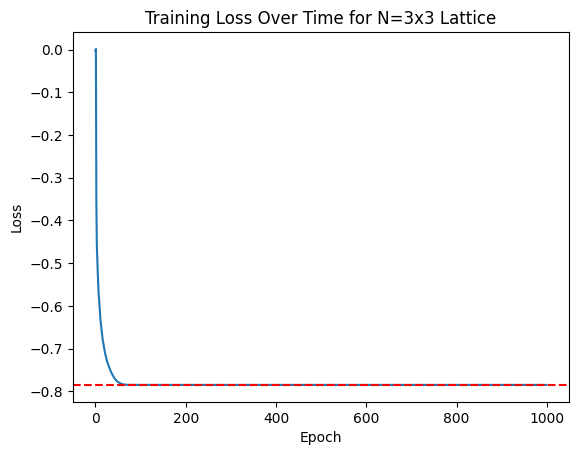

In [7]:
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=3x3 Lattice')
plt.show()